In [1]:
%run circuit_dynamics_init.py # all needed functions 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format ='retina' #plot high-res img 
%load_ext line_profiler

### Possible parallel strategy: 

i) because the order dot product of different $U_n$ matrices with psi
is not relevant, we can generate $L/2$ #s of $U_n$ parallelly and send back to the master rank.
but we still have to apply the dot product sequentially in order to update the wavefunction 
in a recursive manner
        
ii) using a more low level approach by paralleling the kronecker product using MPI.
        
iii) Since we know the sparse matrix will be block diagonal 
with identical blocks, i.e., for each i, un = np.repeat\[blk, $2^{2*i}$ \],
where all blocks take the form $\textrm{blk}=\textrm{kron}(u, \textrm{identity_mat}(2^{(L-2i-2)}$)


it's easy to perform parallel dot operations by extracting different portions of 
the wavefunction and then join the vector back, 
i.e., new_vec = join(dot(blk, vec\[index with the length of blk\]))
        
Note: the sequential version of method (iii) doesn't work well
        
iv) The kronecker product between two matrices A and B can be obtained by 
the outer product of A_row with B_row, say, Outer\[$A_1, B_1$\] gives the first row of 
the resulting matrix. So we can compute the outer product in parallel 
(also calculate the corresponding dot product with the wavefunction at the same time)
and gather the resulting dot product, thus eliminating the need to compute the whole 
large sparse matrix.      

v) Simplest one: after evolving around $2 L$ time steps, the wavefunction reaches a steady state.
We can use the this wavefunction as an input to multiple nodes using MPI to gather 
enough data points (embarrassing parallel)

vi) By profiling the code we find the most time-consuming part of the code is for the unitary evolution. 

#### Import physical parameters and initialize wavefunction 

In [2]:
# reading parameters from file
para = open('para_haar.txt', 'r')
para = para.readlines()
# the paramters are system size, measurement probability and discrete time steps
L,  pro, time = int(para[0]), float(para[1]), int(para[2])

# system partition
# with PBC, we partition system into 4 parts where a and b separated by c1 and c2
# c1 and c2 are effectively connected, so the system is composed of A, B and C
lc1, la, lb = int(np.floor(L/8)), int(np.floor(L/4)), int(np.floor(L/4))
lc2 = L-lc1-la-lb
# pack the partition into array
part = np.array([L, la, lb, lc1, lc2], dtype="int64")

# initializing wavefunctions
p1 = np.ones(1)
p2 = np.zeros(2**L-1,dtype='c16')
# a product state with all spins align up
psi = np.concatenate((p1,p2),axis=0).T
# Pauli z-matrix
sz = sparse.coo_matrix(np.array([[1, 0],[0, -1]]))

In [3]:
%lprun -f evo res = evo(time, psi, pro, L, 2, part)

Timer unit: 1e-06 s

Total time: 6.22352 s
File: /Users/empyriumz/Downloads/Entanglement-Dynamics/circuit_dynamics_init.py
Function: evo at line 340

Line #      Hits         Time  Per Hit   % Time  Line Contents
   340                                           def evo(steps, wave, prob, L, n, partition):
   341         1         18.0     18.0      0.0      von = np.zeros(steps, dtype='float64') # von-Neumann entropy
   342         1          4.0      4.0      0.0      renyi = np.zeros(steps, dtype='float64') # Renyi entropy
   343         1          3.0      3.0      0.0      neg = np.zeros(steps, dtype='float64') # logarithmic negativity
   344         1          3.0      3.0      0.0      mut = np.zeros(steps, dtype='float64') # mutual information using von-Neumann entropy
   345         1          3.0      3.0      0.0      mutr = np.zeros(steps, dtype='float64') # mutual information in terms of Renyi entropy
   346                                               
   347        21   

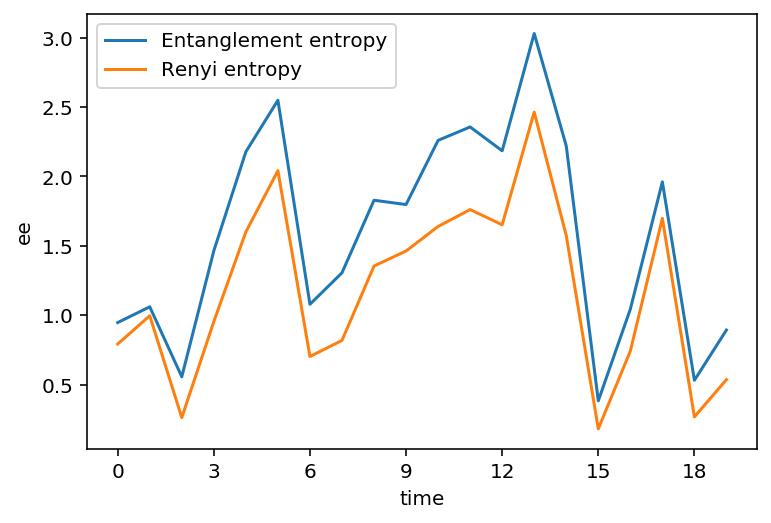

In [18]:
import matplotlib.ticker as mticker
plt.plot(res[0], label='Entanglement entropy')
plt.plot(res[1], label='Renyi entropy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(3))
plt.legend()
plt.ylabel('ee')
plt.xlabel('time')
plt.show()

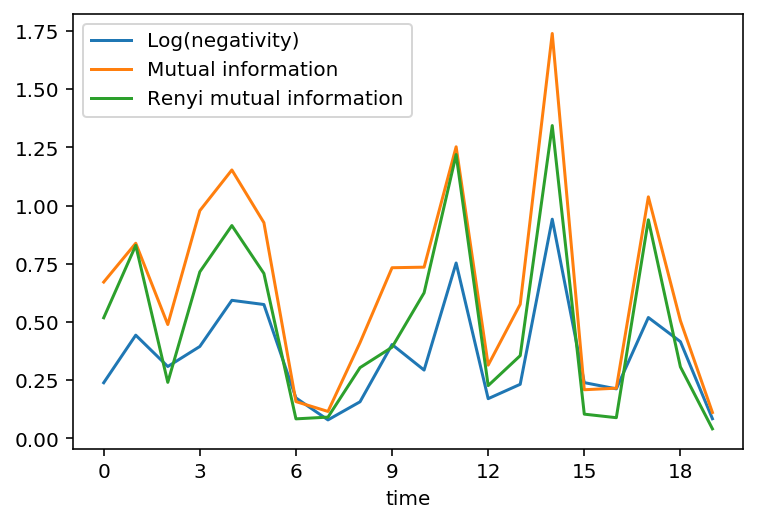

In [19]:
plt.plot(res[2], label='Log(negativity)')
plt.plot(res[3], label='Mutual information')
plt.plot(res[4], label='Renyi mutual information')
#plt.ylabel('log(negativity)')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(3))
plt.xlabel('time')
plt.legend()
plt.show()